# Loading pretrained models

In [1]:
%matplotlib inline
from caffe2.proto import caffe2_pb2
import numpy as np
import skimage.io
import skimage.transform
from matplotlib import pyplot
import os
from caffe2.python import core, workspace, models
import urllib2
print("Required modules imported.")

Required modules imported.


In [32]:
# Configuration --- Change to your setup and preferences!
CAFFE_MODELS = "/usr/local/caffe2/python/models"

# Change image location for different testing! 
IMAGE_LOCATION = "http://www.gettyimages.es/gi-resources/images/Embed/new/embed2.jpg"

MODEL = 'squeezenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 227

codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"

print "Config set!"

Config set!


In the block below we're loading the mean file (if it exists) and the image and then pre-processing the image for ingestion into a Caffe2 convolutional neural network!

In [33]:
# Set functions

def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def rescale(img, input_height, input_width):
    print("Original image shape:" + str(img.shape) + " and remember it should be in H, W, C!")
    print("Model's input shape is %dx%d") % (input_height, input_width)
    aspect = img.shape[1]/float(img.shape[0])
    print("Orginal aspect ratio: " + str(aspect))
    if(aspect>1):
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    if(aspect<1):
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    if(aspect == 1):
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    pyplot.figure()
    pyplot.imshow(imgScaled)
    pyplot.axis('on')
    pyplot.title('Rescaled image')
    print("New image shape:" + str(imgScaled.shape) + " in HWC")
    return imgScaled

In [34]:
# set paths and variables from model choice and prep image
CAFFE_MODELS = os.path.expanduser(CAFFE_MODELS)

# mean can be 128 or custom based on the model
# gives better results to remove the colors found in all of the training images
MEAN_FILE = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    mean = 128
else:
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print "mean was set to: ", mean

# some models were trained with different image sizes, this helps you calibrate your image
INPUT_IMAGE_SIZE = MODEL[4]

INIT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[1])
print 'INIT_NET = ', INIT_NET
PREDICT_NET = os.path.join(CAFFE_MODELS, MODEL[0], MODEL[2])
print 'PREDICT_NET = ', PREDICT_NET
if not os.path.exists(INIT_NET):
    print(INIT_NET + " not found!")
else:
    print "Found ", INIT_NET, "...Now looking for", PREDICT_NET
    if not os.path.exists(PREDICT_NET):
        print "Caffe model file, " + PREDICT_NET + " was not found!"
    else:
        print "All needed files found! Loading the model in the next block."


mean was set to:  128
INIT_NET =  /usr/local/caffe2/python/models/squeezenet/init_net.pb
PREDICT_NET =  /usr/local/caffe2/python/models/squeezenet/predict_net.pb
Found  /usr/local/caffe2/python/models/squeezenet/init_net.pb ...Now looking for /usr/local/caffe2/python/models/squeezenet/predict_net.pb
All needed files found! Loading the model in the next block.


Original image shape:(359, 500, 3) and remember it should be in H, W, C!
Model's input shape is 227x227
Orginal aspect ratio: 1.39275766017
New image shape:(227, 316, 3) in HWC
After crop:  (227, 316, 3)


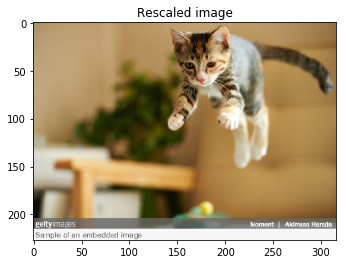

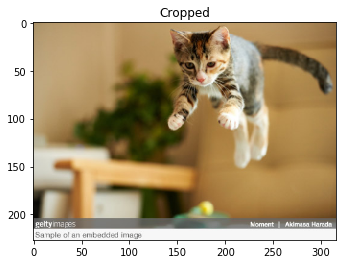

In [44]:
# load and transform image
img = skimage.img_as_float(skimage.io.imread(IMAGE_LOCATION)).astype(np.float32)
img = rescale(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
#img = crop_center(img, INPUT_IMAGE_SIZE, INPUT_IMAGE_SIZE)
print "After crop: " , img.shape
pyplot.figure()
pyplot.imshow(img)
pyplot.axis('on')
pyplot.title('Cropped')

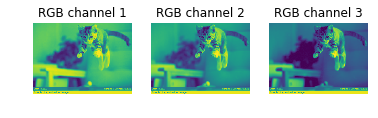

In [45]:
# switch to CHW
img = img.swapaxes(1, 2).swapaxes(0, 1)
pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(img[i])
    pyplot.axis('off')
    pyplot.title('RGB channel %d' % (i+1))

In [46]:
# switch to BGR
img = img[(2, 1, 0), :, :]

# remove mean for better results
img = img * 255 - mean

# add batch size
img = img[np.newaxis, :, :, :].astype(np.float32)
print "NCHW: ", img.shape

NCHW:  (1, 3, 227, 316)


In [47]:
# initialize the neural net

with open(INIT_NET) as f:
    init_net = f.read()
with open(PREDICT_NET) as f:
    predict_net = f.read()
    
p = workspace.Predictor(init_net, predict_net)

# run the net and return prediction
results = p.run([img])

# turn it into something we can play with and examine which is in a multi-dimensional array
results = np.asarray(results)

print "results shape: ", results.shape

results shape:  (1, 1, 1000, 1, 1)


In [48]:
# The rest of this is digging through the results
results = np.delete(results, 1)
index = 0
highest = 0
arr = np.empty((0,2), dtype=object)
arr[:, 0] = int(10)
arr[:, 1:] = float(10)

for i, r in enumerate(results):
    # imagenet index 
    i = i + 1
    arr = np.append(arr, np.array([[i,r]]), axis=0)
    if (r > highest):
        highest = r
        index = i
        
# Top 3 results
print "Raw top 3 results:", sorted(arr, key=lambda x: x[1], reverse=True)[:3]



Raw top 3 results: [array([281.0, 0.5777332186698914], dtype=object), array([282.0, 0.09084248542785645], dtype=object), array([285.0, 0.047622278332710266], dtype=object)]


In [49]:
# now we can grab the code list
response = urllib2.urlopen(codes)

# and lookup our result from the list
for line in response:
    code, result = line.partition(":")[::2]
    if (code.strip() == str(index)):
        print MODEL[0], "infers that the image contains ", result.strip()[1:-2], "with a ", highest*100, "% probability"


squeezenet infers that the image contains  tabby, tabby cat with a  57.773321867 % probability
